## Goal of this notebook

Copy the entire get_J_terms here.
See if we can close if we bin diffusion at the gateway T and S rather than the center T and S.

In [1]:
# auto-reload edited modules
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, "/home/mmurakami/crios_backups/an_helper_functions")

# run the script into the current kernel (vars/functions become available)
%run -i "/home/mmurakami/crios_backups/an_helper_functions/load_packages.py"

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [2]:
from matplotlib.ticker import FuncFormatter, MaxNLocator

In [3]:
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt_aste = 600
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)

times = {}
times["2016"] = np.arange(1,3,1)

# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

t2 = int(tsstr[1])    # this is the averages file that we want to read from when we do budgeting

dt = datetimes[1]-datetimes[0]   # days
dt = dt.total_seconds()
dt

2678400.0

In [122]:
# we will hard code some example box with gates for now
xs = np.array([[25,26,27],[25,26,27],[25,26,27]])
ys = np.array([[525,525,525],[526,526,526],[527,527,527]])

xs = np.array([[25,26],[25,26],[25,26]])
ys = np.array([[525,525],[526,526],[527,527]])

# 10x10 grid continuing your pattern
xs = np.tile(np.arange(25, 35), (10, 1))                 # each row: 25..34
ys = np.tile(np.arange(525, 535).reshape(10, 1), (1, 10))  # each col: 525..534

xs = np.tile(np.arange(2, 36), (15, 1))                  # shape (15, 34)
ys = np.tile(np.arange(520, 535).reshape(15, 1), (1, 34))  # shape (15, 34)

print(xs.shape, ys.shape)   # (15, 34) (15, 34)

print(xs.shape, ys.shape)  # (10, 10) (10, 10)

gatei = np.nanmin(xs)
gateip1 = np.nanmax(xs)
gateip3 = np.nanmax(xs) + 1   # the eastern "gate" index for this range,  we take -advx
gatej = np.nanmin(ys)
gatejp1 = np.nanmin(ys) + 1   # the northern "gate" index we take at j+1 for -advy
gatejp2 = np.nanmax(ys) +1
gatejp2

print(gatei,gateip3)
print(gatej,gatejp2)
x1d = xs.ravel()  # or xs.flatten()
y1d = ys.ravel()

(15, 34) (15, 34)
(15, 34) (15, 34)
2 36
520 535


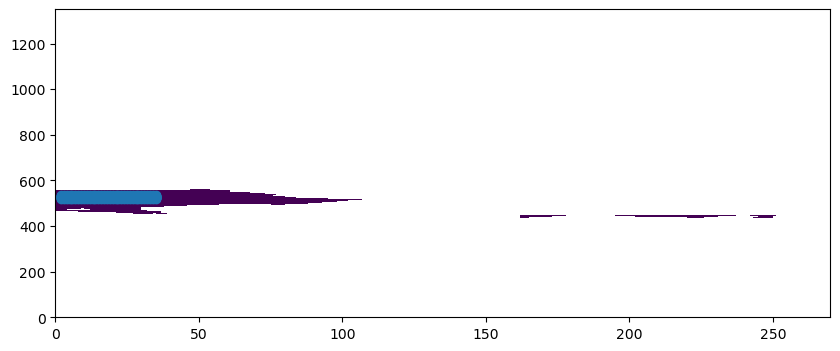

In [123]:
plt.pcolormesh(mymsk)
plt.scatter(xs,ys)
# plt.xlim(23,40)
# plt.ylim(520,540)

## Load the variables we need for the salt budget

In [124]:
# total tendency will just be for those two squares
print("doing salt budget")
# create the salt budget
AB_gT=0
AB_gS=0
file_name = 'budg3d_snap_set2'
meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_snap_set2["fldList"])
varnames = np.array(["SALTDR"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])


SALTDR = np.full((len(tsstr),nz,ny,nx),np.nan)
for i in range(len(tsstr)):
    thisSALTDR,its,meta = rdmds(os.path.join(dirIn, file_name),int(tsstr[i]),returnmeta=True,rec=recs[0])
    thisSALTDR = thisSALTDR.reshape(nz,ny,nx)
    SALTDR[i] = thisSALTDR

SALTDR =  (SALTDR[1, :, :,:] - SALTDR[0, :,:, :]) / dt    # PSU.m/s

tmptend = myparms['rhoconst'] * (SALTDR - AB_gS) * mk3D_mod(RAC,SALTDR)    # kg/m^3 * PSU.m/s * m^2 = g/s
budgO = {}
budgO['saltfluxes'] = {}
budgI = {}
budgI['saltfluxes'] = {}
budgOI = {}

# ocean
budgO['saltfluxes']['tend'] = tmptend
budgO['salttend'] = np.nansum(tmptend,axis=0)

doing salt budget


In [125]:
# load the T and S so we can look at the overall salt tend of the little box

# let's load the Tbins and the Sbins for these columns
# set for all months
vol = np.zeros((len(tsstr),nz, ny, nx))
#print("volume allocation shape",vol.shape)

for t in range(len(tsstr)):
    tmpvol = np.tile(mygrid['DXG'][np.newaxis,:,:],(50,1,1)) * np.tile(mygrid['DYG'][np.newaxis,:,:],(50,1,1)) * DRF3d

    vol[t,:,:,:] = tmpvol * np.tile(mymsk, (nz, 1, 1))
#######
print("doing TS binning")
# read theta and salt averages from the t2 timestep (average)
file_name = "state_3d_set1"
meta_budg3d_kpptend_set1 = parsemeta(dirState + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_kpptend_set1["fldList"])
varnames = np.array(["THETA","SALT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
THETA,its,meta = rdmds(os.path.join(dirState, file_name),t2,returnmeta=True,rec=recs[0])
SALT,its,meta = rdmds(os.path.join(dirState, file_name),t2,returnmeta=True,rec=recs[1])

THETA = THETA.reshape(nz,ny,nx) * np.tile(mymsk[np.newaxis,:,:],(nz,1,1))
SALT = SALT.reshape(nz,ny,nx) * np.tile(mymsk[np.newaxis,:,:],(nz,1,1))

# create the bins of TS data
n_bins = 112

T_min, T_max = -2.0, 15.0
S_min, S_max = 28.0, 37.0

# T_min, T_max = -2.0, 115.0
# S_min, S_max = 20.0, 45.0

# edges and centers
binsTH_edges   = np.linspace(T_min, T_max, n_bins + 1)
binsSLT_edges  = np.linspace(S_min, S_max, n_bins + 1)
binsTH_centers = 0.5 * (binsTH_edges[:-1]  + binsTH_edges[1:])
binsSLT_centers= 0.5 * (binsSLT_edges[:-1] + binsSLT_edges[1:])

nT = nS = n_bins

# 2D bin grids
Tbin,     Sbin     = np.meshgrid(binsTH_edges,  binsSLT_edges)
Tbincent, Sbincent = np.meshgrid(binsTH_centers, binsSLT_centers)

# bin widths and reshaped versions (match downstream shape)
binwidthT = np.diff(binsTH_edges)
binwidthS = np.diff(binsSLT_edges)
dT, dS = np.meshgrid(binwidthT, binwidthS)
dT = dT.reshape(n_bins, n_bins, 1)
dS = dS.reshape(n_bins, n_bins, 1)

# bin theta and salt
binned_theta = bin_array(THETA, binsTH_edges).astype(float)
binned_theta[binned_theta == nT] = np.nan  # handle right-edge assignment

binned_salinity = bin_array(SALT, binsSLT_edges).astype(float)
binned_salinity[binned_salinity == nS] = np.nan

doing TS binning


In [126]:
# we only really care about the binned_salinity for this region
binned_salinity_col = binned_salinity[:,ys,xs]    # nz,3,3
binned_theta_col = binned_theta[:,ys,xs]

In [127]:
hfcsel = mygrid['hFacC']

In [128]:
# just hard code the bin widths T and S for now because this doesn't make sense
binwidthTconst = np.nanmax(binwidthT)
binwidthSconst = np.nanmax(binwidthS)

In [129]:
# plot the TS distribution of the salt tend

tend_S = np.zeros((nS,nT))

for i,j in zip(x1d,y1d):
    nzna = len(hfcsel[:,j,i][~np.isnan(hfcsel[:,j,i])])
    for k in range(nz):
        mytendtmp = budgO['saltfluxes']['tend'][k,j,i]  # g/s
        
        iTpt = int(binned_theta[k, j, i])
        iSpt = int(binned_salinity[k, j, i])
        
        tend_S[iSpt,iTpt] += mytendtmp / myparms['rhoconst'] * 1e-6   # Sv

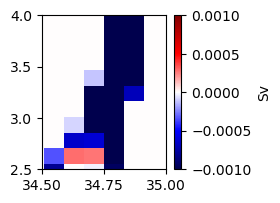

In [130]:
fig = plt.figure(figsize = (2,2))

ax = plt.subplot(111)
cb = ax.pcolormesh(Sbin,Tbin,tend_S,cmap='seismic',vmin=-.001,vmax=.001)
ax.set_xlim(34.5,35)
ax.set_ylim(2.5,4)
plt.colorbar(cb,label="Sv")

## Create the face T and S values

In [131]:
THETA_face_i = np.full((nz,ny,nx),np.nan)      # for the left and right faces
THETA_face_j = np.full((nz,ny,nx),np.nan)      # for the bottom and top (y) faces)
THETA_face_z = np.full((nz,ny,nx),np.nan)    # for the face at top and bottom from k=1 down

# we will only be able to fill between faces i=0 -- i=-2
# we should also do this within each of the faces based on the algorithm in calc_UV_conv_mod
# these points are in face 3 so maybe we can get away with doing a shortcut for now with just that in mind - but it will not work otherwise
# we will need to handle the difference between the two faces
THETA_face_j[:,1:,:] = 0.5*(THETA[:,1:,:] + THETA[:,:-1,:])
# THETA_face is now defined with the avg theta at the LEFT face of the cube - we still need to bin this
THETA_face_j[1:,:,:] = 0.5*(THETA[1:,:,:] + THETA[:-1,:,:])
THETA_face_i[:,:,1:] = 0.5*(THETA[:,:,1:] + THETA[:,:,:-1])

# do the same for SALT
SALT_face_z = np.full((nz,ny,nx),np.nan)      # for the left and right faces
SALT_face_j = np.full((nz,ny,nx),np.nan)    # for the face at top and bottom from k=1 down
SALT_face_i = np.full((nz,ny,nx),np.nan)    # for the face at top and bottom from k=1 down
SALT_face_j[:,1:,:] = 0.5*(SALT[:,1:,:] + SALT[:,:-1,:])
SALT_face_z[1:,:,:] = 0.5*(SALT[1:,:,:] + SALT[:-1,:,:])   # salt is defined as the face below the top one from down
SALT_face_i[:,:,1:] = 0.5*(SALT[:,:,1:] + SALT[:,:,:-1])


# now bin these values
binned_theta_face_i = bin_array(THETA_face_i, binsTH_edges).astype(float)
binned_theta_face_i[binned_theta_face_i == nT] = np.nan  # handle right-edge assignment
binned_theta_face_j = bin_array(THETA_face_j, binsTH_edges).astype(float)
binned_theta_face_j[binned_theta_face_j == nT] = np.nan  # handle right-edge assignment
binned_theta_face_z = bin_array(THETA_face_z, binsTH_edges).astype(float)
binned_theta_face_z[binned_theta_face_z == nT] = np.nan  # handle right-edge assignment

binned_salinity_face_i = bin_array(SALT_face_i, binsSLT_edges).astype(float)
binned_salinity_face_i[binned_salinity_face_i == nS] = np.nan
binned_salinity_face_j = bin_array(SALT_face_j, binsSLT_edges).astype(float)
binned_salinity_face_j[binned_salinity_face_j == nS] = np.nan
binned_salinity_face_z = bin_array(SALT_face_z, binsSLT_edges).astype(float)
binned_salinity_face_z[binned_salinity_face_z == nS] = np.nan

## Load the variables that we need for other terms

In [132]:
print("doing salt budget")

# read adv and dfe
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["ADVx_SLT","ADVy_SLT","DFxE_SLT","DFyE_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVx_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
ADVy_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFxE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
DFyE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])

tmpUo = myparms['rhoconst'] * (ADVx_SLT + DFxE_SLT)
tmpVo = myparms['rhoconst'] * (ADVy_SLT + DFyE_SLT)

# reshape and get the faces
tmpUo = tmpUo.reshape(nz,ny,nx)
tmpVo = tmpVo.reshape(nz,ny,nx)
tmpUo = get_aste_faces(tmpUo,nfx,nfy)              
tmpVo = get_aste_faces(tmpVo,nfx,nfy)

budgO['saltfluxes']['hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo)
budgO['salthconv'] = calc_UV_conv_mod(nfx,nfy,np.nansum(tmpUo,axis=0),np.nansum(tmpVo,axis=0))


# also do hconv for ADV and DF
tmpUo = get_aste_faces(ADVx_SLT.reshape(nz,ny,nx),nfx,nfy)
tmpVo = get_aste_faces(ADVy_SLT.reshape(nz,ny,nx),nfx,nfy)
budgO['saltfluxes']['ADV_hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo) * myparms['rhoconst'] #g/s

tmpUo = get_aste_faces(DFxE_SLT.reshape(nz,ny,nx),nfx,nfy)
tmpVo = get_aste_faces(DFyE_SLT.reshape(nz,ny,nx),nfx,nfy)
budgO['saltfluxes']['DF_hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo) * myparms['rhoconst'] #g/s

# read the vars
file_name = "budg2d_hflux_set1"
meta_budg2d_hflux_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_hflux_set1["fldList"])
varnames = np.array(["ADVxHEFF","ADVyHEFF","DFxEHEFF","DFyEHEFF"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVxHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
ADVyHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFxEHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
DFyEHEFF,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])
ADVxHEFF = ADVxHEFF.reshape(ny,nx)
ADVyHEFF = ADVxHEFF.reshape(ny,nx)
DFxEHEFF = DFxEHEFF.reshape(ny,nx)
DFyEHEFF = DFyEHEFF.reshape(ny,nx)
    
if myparms['seaice_variable_salinity_flag'] == 0:
    SIsal0 = myparms['SIsal0']

tmpUi = SIsal0 * myparms['rhoi'] * (DFxEHEFF + ADVxHEFF)
tmpVi = SIsal0 * myparms['rhoi'] * (DFyEHEFF + ADVyHEFF)
tmpUi = get_aste_faces(tmpUi,nfx,nfy)              
tmpVi = get_aste_faces(tmpVi,nfx,nfy)

budgI['salthconv'] = calc_UV_conv_mod(nfx,nfy,tmpUi, tmpVi)
budgOI['salthconv'] = (budgO['salthconv'] + budgI['salthconv'])


# read fluxes
file_name = 'budg2d_zflux_set1'
meta_budg2d_zflux_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set1["fldList"])
varnames = np.array(["oceSPflx","SFLUX"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
oceSPflx,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
SFLUX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
oceSPflx = oceSPflx.reshape(ny,nx)
SFLUX = SFLUX.reshape(ny,nx)

# read relax and salt mass
file_name = "budg2d_zflux_set2"
meta_budg2d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set2["fldList"])
varnames = np.array(["oceSflux","WSLTMASS","SRELAX"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])
oceSflux,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
WSLTMASS,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
SRELAX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
oceSflux = oceSflux.reshape(ny,nx)
WSLTMASS = WSLTMASS.reshape(ny,nx)
SRELAX = SRELAX.reshape(ny,nx)


# read kpp tend and from 3d zflux
file_name = "budg3d_kpptend_set1"
meta_budg3d_kpptend_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_kpptend_set1["fldList"])
varnames = np.array(["oceSPtnd","KPPg_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])
oceSPtnd,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
KPPg_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
oceSPtnd = oceSPtnd.reshape(nz,ny,nx)
KPPg_SLT = KPPg_SLT.reshape(nz,ny,nx)


# now 3d zfluxes
file_name = "budg3d_zflux_set2"
meta_budg3d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_zflux_set2["fldList"])
varnames = np.array(["ADVr_SLT","DFrE_SLT","DFrI_SLT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVr_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
DFrE_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFrI_SLT,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
ADVr_SLT = ADVr_SLT.reshape(nz,ny,nx)
DFrE_SLT = DFrE_SLT.reshape(nz,ny,nx)
DFrI_SLT = DFrI_SLT.reshape(nz,ny,nx)

if myparms["useRFWF"]==0 or myparms['useNLFS']==0:
    print('do nothing')
else:
    oceSflux = 0 * oceSflux

if myparms['useNLFS'] == 0:
    print('do nothing, already read above')
else:
    WSLTMASS=0*WSLTMASS

budgO['saltzconv'] = SFLUX + oceSPflx                  # W/m^2
zconv_top_salt = (SFLUX + oceSPflx) * RAC               # g/s
budgI['saltzconv'] = -budgO['saltzconv'] + SRELAX

if myparms['useNLFS']==0:
    budgO['saltzconv'] = budgO['saltzconv'] - myparms['rhoconst']*WSLTMASS

if myparms['useRFWF']==0 or myparms['useNLFS']==0:
    budgI['saltzconv']=-oceSflux


nr = mygrid['RC'].shape[0]
# break trWtop down into smaller terms
trWtopADV = -(ADVr_SLT)*myparms['rhoconst']           # g/s
trWtopDF = -(DFrE_SLT+DFrI_SLT)*myparms['rhoconst']   # g/s
trWtopKPP = -(KPPg_SLT)*myparms['rhoconst']           # g/s
trWtop = trWtopADV + trWtopDF + trWtopKPP             # g/s 

#print(trWtop.shape)
sptop = mk3D_mod(oceSPflx,oceSPtnd) - np.cumsum(oceSPtnd, axis=0)        # we include this in our zconv_top term
sptop = sptop * RAC3        # g/s

trWtop[1:,:,:] = trWtop[1:,:,:] + sptop[:-1,:,:]
trWtop[0,:,:] = budgO['saltzconv'] * RAC    # g/s top layer is surface flux

trWbot = np.zeros_like(trWtop)
trWbot[:-1,:,:] = trWtop[1:,:,:]
trWbot[-1,:,:] = 0

budgO['saltfluxes']['trWtop'] = trWtop     # g/s
budgO['saltfluxes']['trWbot'] = trWbot     # g/s

budgI['saltfluxes']['trWtop'] = -RAC*0
budgI['saltfluxes']['trWbot'] = budgO['saltfluxes']['trWtop'][0,:,:]  # surface because ice

budgO['saltfluxes']['zconv'] = budgO['saltfluxes']['trWtop'] - budgO['saltfluxes']['trWbot']
budgO['saltzconv'] = RAC * budgO['saltzconv']   # g/s
budgI['saltzconv'] = RAC * budgI['saltzconv']   # g/s
budgOI['saltzconv'] = budgO['saltzconv'] + budgI['saltzconv']

# do vertical convergence for ADV and DF terms
tmpadv = np.full((nz,ny,nx),np.nan)
tmpadv[:-1,:,:] = (trWtopADV[:-1] - trWtopADV[1:])              # for surface thru seafloor

Sconv = budgO['saltfluxes']['ADV_hconv'] + tmpadv
budgO['saltfluxes']['ADV_Sconv'] = Sconv             # g/s, this is the advective arrow of S for a 

# do vertical convergence for ADV and DF terms
tmpdf = np.full((nz,ny,nx),np.nan)
tmpdf[:-1,:,:] = (trWtopDF[:-1] - trWtopDF[1:])              # for surface thru seafloor

dfSconv = budgO['saltfluxes']['DF_hconv'] + tmpdf
budgO['saltfluxes']['DF_Sconv'] = dfSconv             # g/s, this is the diffusive arrow of T for a cell


tmpkpp = np.full((nz,ny,nx),np.nan)
tmpkpp[:-1,:,:] = trWtopKPP[:-1] - trWtopKPP[1:]
budgO['saltfluxes']['KPP_Sconv'] = tmpkpp        # no horizontal component for this

doing salt budget


In [133]:
# # # redefine gatesS and gatesT
# gatesS_N = np.zeros((nz, 2))
# gatesS_S = np.zeros((nz, 2))
# gatesS_E = np.zeros((nz, 1))
# gatesS_W = np.zeros((nz, 1))

# # --- WEST gate (left side) ---
# gatesS_W[:, 0] = tmpADVx_SLT[:, gatej, gatei] / SW            # m^3/s

# # --- EAST gate (right side) ---
# gatesS_E[:, 0] = -tmpADVx_SLT[:, gatej, gateip2] / SE         # m^3/s

# # --- SOUTH gate (bottom) ---
# gatesS_S[:, 0] = tmpADVy_SLT[:, gatej, gatei] / SSW 
# gatesS_S[:, 1] = tmpADVy_SLT[:, gatej, gateip1] / SSE

# # --- NORTH gate (top) ---
# gatesS_N[:, 0] = -(tmpADVy_SLT[:, gatejp1, gatei]) / SNW
# gatesS_N[:, 1] = -(tmpADVy_SLT[:, gatejp1, gateip1]) / SNE    # m^3/s

In [141]:
# given your patch
xs2d = np.array([[25,26,27],
                 [25,26,27],
                 [25,26,27]])
ys2d = np.array([[525,525,525],
                 [526,526,526],
                 [527,527,527]])

xs2d = np.array([[25,26],
                 [25,26],
                 [25,26]])
ys2d = np.array([[525,525,],
                 [526,526,],
                 [527,527,]])

# 10x10 grid continuing your pattern
xs2d = np.tile(np.arange(25, 35), (10, 1))                 # each row: 25..34
ys2d = np.tile(np.arange(525, 535).reshape(10, 1), (1, 10))  # each col: 525..534

xs2d = np.tile(np.arange(2, 36), (15, 1))                  # shape (15, 34)
ys2d = np.tile(np.arange(520, 535).reshape(15, 1), (1, 34))  # shape (15, 34)

print(xs.shape, ys.shape)   # (15, 34) (15, 34)

# print(xs.shape, ys.shape)  # (10, 10) (10, 10)

# 1) build a boolean mask for boundary points of the patch
x_vals = xs2d[0, :]
y_vals = ys2d[:, 0]
i_min, i_max = x_vals[0], x_vals[-1]
j_min, j_max = y_vals[0], y_vals[-1]

# mask over (ny, nx): True on the patch boundary, False elsewhere
mask2d = np.zeros((ny, nx), dtype=bool)
mask2d[j_min:j_max+1, [i_min, i_max]] = True        # left & right edges
mask2d[[j_min, j_max], i_min:i_max+1] = True        # bottom & top edges

# 2) make masked copies of your fields, zeroing boundary cells
adv_hconv_masked = budgO['saltfluxes']['ADV_hconv'].copy()  # (nz,ny,nx)
adv_hconv_masked[:, mask2d] = 0.0

# vertical convergence part (you can keep as-is, or also zero at boundary columns)
tmpadv = np.full((nz, ny, nx), np.nan)
tmpadv[:-1, :, :] = (trWtopADV[:-1] - trWtopADV[1:])  # vertical (z) part

tmpadv_masked = tmpadv.copy()
tmpadv_masked[:, mask2d] = 0.0   # optional; keeps only interior columns

# 3) combine to get the masked convergence
Sconv2 = adv_hconv_masked + tmpadv_masked

(15, 34) (15, 34)


In [142]:
print("doing JtermsS")
# initialize the J vectors for salt
JtermsS = np.zeros((6,nS,nT))

# get the values
aS = budgO['saltfluxes']['tend']
bS = budgO['saltfluxes']['ADV_Sconv']
cS = budgO['saltfluxes']['DF_Sconv']
dS = budgO['saltfluxes']['KPP_Sconv']
eS = zconv_top_salt.reshape(1,ny,nx)
fS = sptop

for j,i in zip(y1d,x1d):

    # loop through the depths and add
    nzna = len(hfcsel[:,j,i][~np.isnan(hfcsel[:,j,i])]) # how many cells are filled here
    
    for k in range (nzna):
        iTpt = int(binned_theta[k,j,i])
        iSpt = int(binned_salinity[k,j,i])
    
        # save the J terms for here for the single point   
        JtendS = (aS[k,j,i]) / myparms['rhoconst'] / binwidthS[iSpt] * 1e-6             # Sv
        JADVS = (bS[k,j,i]) / myparms['rhoconst'] / binwidthS[iSpt] * 1e-6              # Sv
        JDFS = (cS[k,j,i]) / myparms['rhoconst'] / binwidthS[iSpt] * 1e-6               # Sv
        JKPPS = (dS[k,j,i]) / myparms['rhoconst'] / binwidthS[iSpt] * 1e-6              # Sv

        # surface term will be unique
        if k == 0:
            JsurfS = (eS[k,j,i] - fS[k+1,j,i]) / myparms['rhoconst'] / binwidthS[iSpt] * 1e-6  # Sv
        else:
            JsurfS = -(fS[k,j,i] - fS[k-1,j,i]) / myparms['rhoconst'] / binwidthS[iSpt] * 1e-6  # Sv

        # set these in meshes so we can plot
        c = 0
        for valS in (np.array([JtendS,JADVS,JDFS,JKPPS,JsurfS])):
            #print(valT)
            JtermsS[c,iSpt,iTpt] += valS
            c += 1
        JtermsS[5,iSpt,iTpt] += Sconv2[k,j,i] / myparms['rhoconst'] / binwidthS[iSpt] * 1e-6              # Sv

print("total resid: ",np.nansum(JtermsS[0] - JtermsS[1] - JtermsS[2] - JtermsS[3] - JtermsS[4]))

doing JtermsS
total resid:  -2.7424653657479006e-11


(2.5, 4.0)

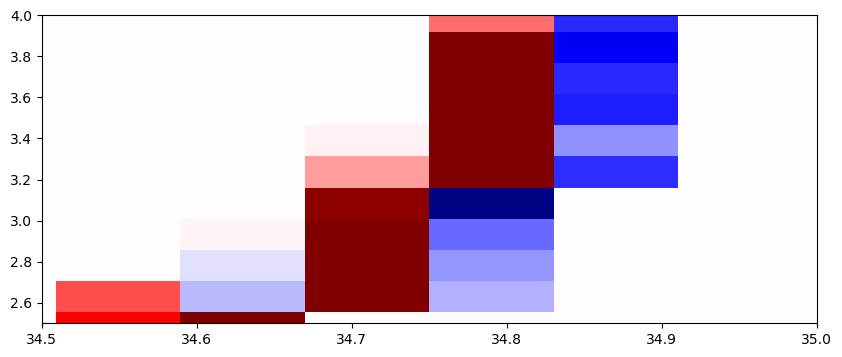

In [143]:
plt.pcolormesh(Sbin,Tbin,JtermsS[1] - JtermsS[5],cmap='seismic',vmin=-.01,vmax=.01)
plt.xlim(34.5,35)
plt.ylim(2.5,4)

In [144]:

# unique coords in order (assumes a rectilinear block)
x_vals = xs[0, :]          # [25, 26, 27]
y_vals = ys[:, 0]          # [525, 526, 527]

# infer spacing (fallback 1 if single cell)
dxs = np.unique(np.diff(x_vals))
dys = np.unique(np.diff(y_vals))
dx = dxs[0] if dxs.size else 1
dy = dys[0] if dys.size else 1

i_min, i_max = x_vals[0], x_vals[-1]
j_min, j_max = y_vals[0], y_vals[-1]

# gates (faces just outside the patch on right/top)
leftx  = np.full_like(y_vals, i_min)
lefty  = y_vals.copy()

rightx = np.full_like(y_vals, i_max + dx)
righty = y_vals.copy()

botx   = x_vals.copy()
boty   = np.full_like(x_vals, j_min)

topx   = x_vals.copy()
topy   = np.full_like(x_vals, j_max + dy)

print(leftx, lefty)
print(botx, boty)
print(rightx, righty)
print(topx, topy)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2] [520 521 522 523 524 525 526 527 528 529 530 531 532 533 534]
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35] [520 520 520 520 520 520 520 520 520 520 520 520 520 520 520 520 520 520
 520 520 520 520 520 520 520 520 520 520 520 520 520 520 520 520]
[36 36 36 36 36 36 36 36 36 36 36 36 36 36 36] [520 521 522 523 524 525 526 527 528 529 530 531 532 533 534]
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35] [535 535 535 535 535 535 535 535 535 535 535 535 535 535 535 535 535 535
 535 535 535 535 535 535 535 535 535 535 535 535 535 535 535 535]


In [145]:
ADVx_SLT= ADVx_SLT.reshape(nz,ny,nx)
ADVy_SLT= ADVy_SLT.reshape(nz,ny,nx)

In [146]:
# this is where we try to put the salt terms into a TS mesh
# we need to go through the ADV points in each gate and add them to the TS bin at that point
binwidthTconst = np.nanmax(binwidthT)
binwidthSconst = np.nanmax(binwidthS)
norm = (binwidthTconst * binwidthSconst * myparms['rhoconst'])

J_gates = np.zeros((4,nS,nT))

#########################################################################################################################
for j,i in zip(lefty,leftx):
    # based on the direction, grab from ADV_gates at the correct index
    col = ADVx_SLT[:,j,i]

    nzc = len(binned_theta_face_i[:,j,i][~np.isnan(binned_theta_face_i[:,j,i])])
    for kc in range(nzc):
        # get the T and S bin for that item
        iTpt = int(binned_theta_face_i[kc,j,i])
        iSpt = int(binned_salinity_face_i[kc,j,i])
        iTpt = int(binned_theta[kc,j,i])
        iSpt = int(binned_salinity[kc,j,i])
        J_gates[0,iSpt,iTpt] += (col[kc]) / binwidthSconst  #m^3.PSU/s -- g/s -- 


#########################################################################################################################
# do this for SFJ
for j,i in zip(boty,botx):
    # based on the direction, grab from ADV_gates at the correct index
    col = ADVy_SLT[:,j,i]
    nzc = len(binned_theta_face_j[:,j,i][~np.isnan(binned_theta_face_j[:,j,i])])
    for kc in range(nzc):
        # get the T and S bin for that item
        iTpt = int(binned_theta_face_j[kc,j,i])
        iSpt = int(binned_salinity_face_j[kc,j,i])
        iTpt = int(binned_theta[kc,j,i])
        iSpt = int(binned_salinity[kc,j,i])
        J_gates[1,iSpt,iTpt] += (col[kc]) / binwidthSconst

#########################################################################################################################
# same for FJNZ
for j,i in zip(righty,rightx):
    # based on the direction, grab from ADV_gates at the correct index
    col = -ADVx_SLT[:,j,i]
    nzc = len(binned_theta_face_i[:,j,i][~np.isnan(binned_theta_face_i[:,j,i])])
    for kc in range(nzc):
        # get the T and S bin for that item
        iTpt = int(binned_theta_face_i[kc,j,i])
        iSpt = int(binned_salinity_face_i[kc,j,i])
        iTpt = int(binned_theta[kc,j,i-1])
        iSpt = int(binned_salinity[kc,j,i-1])
        J_gates[2,iSpt,iTpt] += (col[kc]) / binwidthSconst

#########################################################################################################################
# same again for NZRU
for j,i in zip(topy,topx):
    # based on the direction, grab from ADV_gates at the correct index
    col = -ADVy_SLT[:,j,i]
    nzc = len(binned_theta_face_j[:,j,i][~np.isnan(binned_theta_face_j[:,j,i])])
    for kc in range(nzc):
        # get the T and S bin for that item
        iTpt = int(binned_theta_face_j[kc,j,i])
        iSpt = int(binned_salinity_face_j[kc,j,i])
        iTpt = int(binned_theta[kc,j-1,i])
        iSpt = int(binned_salinity[kc,j-1,i])
        J_gates[3,iSpt,iTpt] += (col[kc]) / binwidthSconst


#############################################################################################################################
J_gates *= 1e-6  # Sv

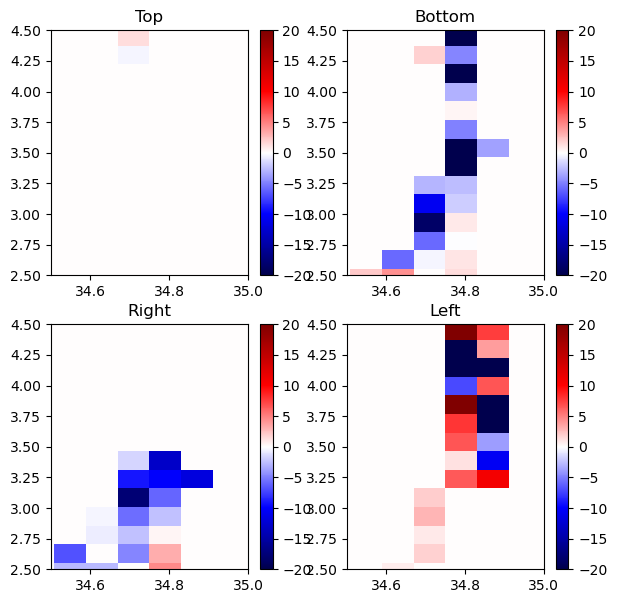

In [147]:
fig = plt.figure(figsize=(7,7))
vlev = 20

ax = plt.subplot(221)
cb=ax.pcolormesh(Sbin,Tbin,J_gates[0],cmap='seismic',vmin=-vlev,vmax=vlev)
ax.set_title("Top")
ax.set_xlim(34.5,35)
ax.set_ylim(2.5,4.5)
plt.colorbar(cb)

ax = plt.subplot(222)
cb=ax.pcolormesh(Sbin,Tbin,J_gates[1],cmap='seismic',vmin=-vlev,vmax=vlev)
ax.set_title("Bottom")
ax.set_xlim(34.5,35)
ax.set_ylim(2.5,4.5)
plt.colorbar(cb)

ax = plt.subplot(223)
cb=ax.pcolormesh(Sbin,Tbin,J_gates[2],cmap='seismic',vmin=-vlev,vmax=vlev)
ax.set_title("Right")
ax.set_xlim(34.5,35)
ax.set_ylim(2.5,4.5)
plt.colorbar(cb)

ax = plt.subplot(224)
cb=ax.pcolormesh(Sbin,Tbin,J_gates[3],cmap='seismic',vmin=-vlev,vmax=vlev)
ax.set_title("Left")
ax.set_xlim(34.5,35)
ax.set_ylim(2.5,4.5)
plt.colorbar(cb)

In [148]:
# ADVx_SLT[:,ys,xs]

In [149]:
# fig = plt.figure()

# ax = plt.subplot(121)
# ax.pcolormesh(np.nansum(ADVx_SLT,axis=0),cmap='seismic',vmin=-5000000,vmax=5000000)
# ax.set_xlim(20,30)
# ax.set_ylim(520,530)
# ax.scatter(xs,ys)

# ax = plt.subplot(122)
# ax.pcolormesh(np.nansum(ADVy_SLT,axis=0),cmap='seismic',vmin=-5000000,vmax=5000000)
# ax.set_xlim(20,30)
# ax.set_ylim(520,530)
# ax.scatter(xs,ys)

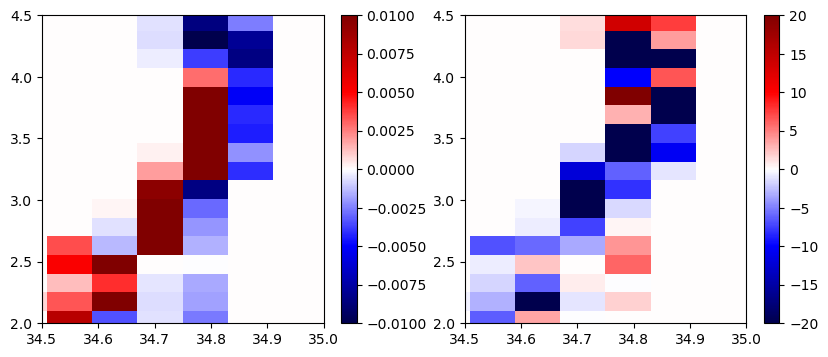

In [150]:
fig = plt.figure()

ax = plt.subplot(121)
cb = ax.pcolormesh(Sbin,Tbin,JtermsS[1]-JtermsS[5],cmap='seismic',vmin=-.01,vmax=.01)
ax.set_xlim(34.5,35)
ax.set_ylim(2,4.5)
plt.colorbar(cb)

ax = plt.subplot(122)
cb = ax.pcolormesh(Sbin,Tbin,np.nansum(J_gates,axis=0),cmap='seismic',vmin=-20,vmax=20)
ax.set_xlim(34.5,35)
ax.set_ylim(2,4.5)
plt.colorbar(cb)

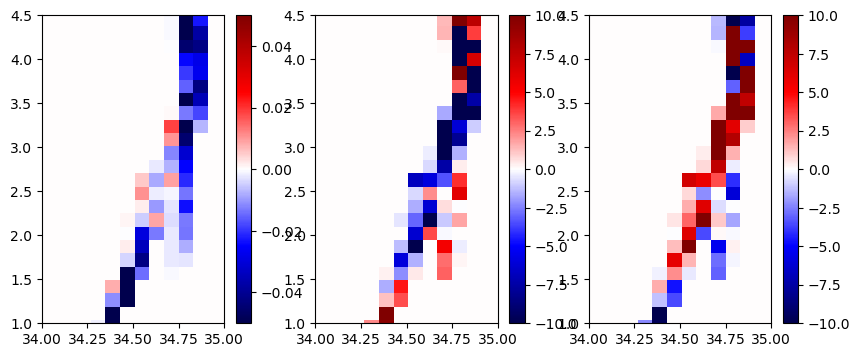

In [151]:
fig = plt.figure()

ax = plt.subplot(131)
cb = ax.pcolormesh(Sbin,Tbin,JtermsS[1],cmap='seismic',vmin=-.05,vmax=.05)
ax.set_xlim(34,35)
ax.set_ylim(1,4.5)
plt.colorbar(cb)

ax = plt.subplot(132)
cb = ax.pcolormesh(Sbin,Tbin,np.nansum(J_gates,axis=0),cmap='seismic',vmin=-10,vmax=10)
ax.set_xlim(34,35)
ax.set_ylim(1,4.5)
plt.colorbar(cb)

ax = plt.subplot(133)
cb = ax.pcolormesh(Sbin,Tbin,JtermsS[1]- np.nansum(J_gates,axis=0) ,cmap='seismic',vmin=-10,vmax=10)
ax.set_xlim(34,35)
ax.set_ylim(1,4.5)
plt.colorbar(cb)

In [152]:
np.nansum(JtermsS[1])

-2.0217130875737404

In [153]:
np.nansum(J_gates)

-2.0217130875737723

## Now we can try to make the theta budget based on the same principle

In [155]:
#############################################################################
print("doing heat budget")
# create the heat budget
# read thetadr
file_name = 'budg3d_snap_set2'
meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_snap_set2["fldList"])
varnames = np.array(["THETADR"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])

THETADR = np.full((len(tsstr),nz,ny,nx),np.nan)
for i in range(len(tsstr)):
    thisTHETADR,its,meta = rdmds(os.path.join(dirIn, file_name),int(tsstr[i]),returnmeta=True,rec=recs[0])
    thisTHETADR = thisTHETADR.reshape(nz,ny,nx)
    THETADR[i] = thisTHETADR

THETADR =  (THETADR[1, :, :,:] - THETADR[0, :,:, :]) / dt    # degC.m/

tmptend=myparms['rcp']*(THETADR-AB_gT)*mk3D_mod(RAC,THETADR)   # J/m^3.degC * degC.m/s * m^2 = J/s
budgO['heatfluxes'] = {}
budgI['heatfluxes'] = {}

budgO['heatfluxes']['tend'] = tmptend     # J/s

budgO['heattend'] = np.nansum(tmptend,axis=0)

file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["ADVx_TH","ADVy_TH","DFxE_TH","DFyE_TH","UVELMASS","VVELMASS"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVx_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
ADVy_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFxE_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
DFyE_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])
# UVELMASS,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[4])
# VVELMASS,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[5])  # m/s

# reshape the UVELMASS and VVELMASS to look at these
# UVELMASS = UVELMASS.reshape(nz,ny,nx)
# VVELMASS = VVELMASS.reshape(nz,ny,nx)

tmpUo = myparms['rcp'] * (ADVx_TH + DFxE_TH)
tmpVo = myparms['rcp'] * (ADVy_TH + DFyE_TH)

tmpUo = tmpUo.reshape(nz,ny,nx)
tmpVo = tmpVo.reshape(nz,ny,nx)

# get the faces so we can do convergence
tmpUo = get_aste_faces(tmpUo,nfx,nfy)              
tmpVo = get_aste_faces(tmpVo,nfx,nfy)

budgO['heatfluxes']['hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo)
budgO['heathconv'] = calc_UV_conv_mod(nfx,nfy,np.nansum(tmpUo, axis=0),np.nansum(tmpVo,axis=0))

# add the budgeting for ADV and DF
tmpUo = get_aste_faces(ADVx_TH.reshape(nz,ny,nx),nfx,nfy)
tmpVo = get_aste_faces(ADVy_TH.reshape(nz,ny,nx),nfx,nfy)
budgO['heatfluxes']['ADV_hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo) * myparms['rcp'] #J/s

tmpUo = get_aste_faces(DFxE_TH.reshape(nz,ny,nx),nfx,nfy)
tmpVo = get_aste_faces(DFyE_TH.reshape(nz,ny,nx),nfx,nfy)
budgO['heatfluxes']['DF_hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo) * myparms['rcp'] #J/s

file_name = 'budg2d_zflux_set1'
meta_budg2d_zflux_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set1["fldList"])
varnames = np.array(["TFLUX","oceQsw","SItflux"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
TFLUX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
oceQsw,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
SItflux,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
TFLUX = TFLUX.reshape(ny,nx)
oceQsw = oceQsw.reshape(ny,nx)
SItflux = SItflux.reshape(ny,nx)

# note: the following works provided that the first 3 terms are definitely there
file_name = "budg2d_zflux_set2"
meta_budg2d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg2d_zflux_set2["fldList"])
varnames = np.array(["oceQnet","WTHMASS","SIaaflux","TRELAX"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
oceQnet,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
WTHMASS,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
SIaaflux,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
TRELAX,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[3])
oceQnet = oceQnet.reshape(ny,nx)
WTHMASS = WTHMASS.reshape(ny,nx)
SIaaflux = SIaaflux.reshape(ny,nx)
TRELAX = TRELAX.reshape(ny,nx)

# note: will not work if these are defined, fix for future steps
varnames = np.array(["TRELAX","SIabflux","SIacflux","SIeprflx","SIfldflx"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    if len(irec[0]) > 0:
        recs = np.append(recs, irec[0][0])

# if len(recs) == 0:
SIabflux = np.zeros((ny, nx))
SIacflux = np.zeros((ny, nx))
SIeprflx = np.zeros((ny, nx))
SIfldflx = np.zeros((ny, nx))
if myparms['useNLFS'] == 0:
    print('do nothing, already read above')
else:
    WTHMASS=0*WTHMASS

geothFlux = 0

if myparms['SaltPlumeHeatFlux']:
    print(1)
else:
    SPforcT1=0*np.ones((ny,nx))
    oceEPtnd=0*np.ones((nz,ny,nx))


# read kpp tend and from 3d zflux
file_name = "budg3d_kpptend_set1"
meta_budg3d_kpptend_set1 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_kpptend_set1["fldList"])
varnames = np.array(["KPPg_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
KPPg_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
KPPg_TH = KPPg_TH.reshape(nz,ny,nx)

# now 3d zfluxes
file_name = "budg3d_zflux_set2"
meta_budg3d_zflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_zflux_set2["fldList"])
varnames = np.array(["ADVr_TH","DFrE_TH","DFrI_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
ADVr_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
DFrE_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])
DFrI_TH,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[2])
ADVr_TH = ADVr_TH.reshape(nz,ny,nx)
DFrE_TH = DFrE_TH.reshape(nz,ny,nx)
DFrI_TH = DFrI_TH.reshape(nz,ny,nx)

budgO['heatzconv']=TFLUX+geothFlux+SPforcT1                           # W/m^2 = J/m^2/s
zconv_top_heat = TFLUX  * RAC     # W/m^2 * m^2 = J/s
budgI['heatzconv']=-(SItflux+TFLUX-TRELAX+SPforcT1)

if myparms['useNLFS']==0:
    print(1)
    budgO['heatzconv']=budgO['heatzconv']-myparms['rcp']*WTHMASS[:,:]     # degC.m/s * J/m^3degC = J/m^2.s

budgI['heatzconv']=budgI['heatzconv']-SIabflux+SIacflux+SIeprflx
if(myparms['SEAICEheatConsFix']==0):
    print(2)
    budgI['heatzconv']=budgI['heatzconv']+SIaaflux

nr = mygrid['RC'].shape[0]
trWtopADV = -(ADVr_TH) * myparms['rcp']         # J/s
trWtopDF = -(DFrE_TH+DFrI_TH) * myparms['rcp']  # J/s
trWtopKPP = -(KPPg_TH) * myparms['rcp']         # J/s
trWtop = trWtopADV + trWtopDF + trWtopKPP       # J/s
dd = mygrid['RF'][:-1]
swfrac = 0.62*np.exp(dd/0.6)+(1-0.62)*np.exp(dd/20)
swfrac[dd < -200] = 0
swtop=mk3D_mod(swfrac,trWtop)*mk3D_mod(RAC*oceQsw,trWtop)   # J/s
mskC=mygrid['mskC']
swtop[np.isnan(mskC)]=0
trWtop=trWtop+swtop  # 323
    
trWtop[0,:,:]=budgO['heatzconv']*RAC
trWbot = np.zeros_like(trWtop)
trWbot[:-1,:,:]=trWtop[1:,:,:]

budgO["heatfluxes"]["trWtop"] = trWtop
budgO["heatfluxes"]["trWbot"] = trWbot

budgI["heatfluxes"]["trWtop"] = -RAC * (budgI["heatzconv"] + budgO["heatzconv"])
budgI["heatfluxes"]["trWbot"] = -RAC * budgO["heatzconv"]
budgO['heatfluxes']['zconv']=budgO['heatfluxes']['trWtop']-budgO['heatfluxes']['trWbot']

budgO['heatzconv'] = RAC*budgO['heatzconv']  # J/s
budgI['heatzconv']=RAC*budgI['heatzconv']    # J/s
budgOI['heatzconv']=budgO['heatzconv']+budgI['heatzconv']

# do vertical convergence for ADV and DF terms
tmpadv = np.full((nz,ny,nx),np.nan)
tmpadv[:-1,:,:] = (trWtopADV[:-1] - trWtopADV[1:])              # for surface thru seafloor

Tconv = budgO['heatfluxes']['ADV_hconv'] + tmpadv   # hconv + zconv
budgO['heatfluxes']['ADV_Tconv'] = Tconv      # J/s, this is the advective arrow of T for a cell

# do vertical convergence for ADV and DF terms
tmpdf = np.full((nz,ny,nx),np.nan)
tmpdf[:-1,:,:] = (trWtopDF[:-1] - trWtopDF[1:])              # for surface thru seafloor

dfTconv = budgO['heatfluxes']['DF_hconv'] + tmpdf
budgO['heatfluxes']['DF_Tconv'] = dfTconv      # J/s, this is the diffusive arrow of T for a cell

tmpkpp = np.full((nz,ny,nx),np.nan)
tmpkpp[:-1,:,:] = trWtopKPP[:-1] - trWtopKPP[1:]
budgO['heatfluxes']['KPP_Tconv'] = tmpkpp        # no horizontal component for this


doing heat budget
2


In [167]:
##########################################################
print("doing JtermsT")
# make this a for loop for points just to start
JtermsT = np.zeros((5,nS,nT))

# get the data (will be the same for all points)
aT = budgO['heatfluxes']['tend']
bT = budgO['heatfluxes']['ADV_Tconv']
cT = budgO['heatfluxes']['DF_Tconv']
dT = budgO['heatfluxes']['KPP_Tconv']
eT = zconv_top_heat.reshape(1,ny,nx)
fT = swtop

for j,i in zip(y1d,x1d):

    # loop through the depths and add
    nzna = len(hfcsel[:,j,i][~np.isnan(hfcsel[:,j,i])]) # how many cells are filled here
    
    for k in range (nzna):
        iTpt = int(binned_theta[k,j,i])
        iSpt = int(binned_salinity[k,j,i])

        # save the J terms for here for the single point   
        JtendT = (aT[k,j,i]) / myparms['rcp'] / binwidthT[iTpt] * 1e-6             # Sv/PSU
        JADVT = (bT[k,j,i]) / myparms['rcp'] / binwidthT[iTpt] * 1e-6              # Sv/PSU
        JDFT = (cT[k,j,i]) / myparms['rcp'] / binwidthT[iTpt] * 1e-6               # Sv/PSU
        JKPPT = (dT[k,j,i]) / myparms['rcp'] / binwidthT[iTpt] * 1e-6              # Sv/PSU

        if k == 0:
            JsurfT = (eT[k,j,i] - fT[k+1,j,i]) / myparms['rcp'] / binwidthT[iTpt] * 1e-6 # Sv/PSU
        else:
            JsurfT = -(fT[k+1,j,i] - fT[k,j,i]) / myparms['rcp'] / binwidthT[iTpt] * 1e-6 # Sv/PSU

        # set these in meshes so we can plot
        c = 0
        for valT in (np.array([JtendT,JADVT,JDFT,JKPPT,JsurfT])):
            #print(valT)
            JtermsT[c,iSpt,iTpt] += valT
            c += 1

print("total residual",np.nansum(JtermsT[0] - JtermsT[1] - JtermsT[2] - JtermsT[3] - JtermsT[4]),"Sv/PSU")

doing JtermsT
total residual -1.9622153734628487e-12 Sv/PSU


In [168]:
ADVx_TH = ADVx_TH.reshape(nz,ny,nx)
ADVy_TH = ADVy_TH.reshape(nz,ny,nx)

In [169]:
# this is where we try to put the salt terms into a TS mesh
# we need to go through the ADV points in each gate and add them to the TS bin at that point
binwidthTconst = np.nanmax(binwidthT)
binwidthSconst = np.nanmax(binwidthS)
norm = (binwidthTconst * binwidthSconst * myparms['rhoconst'])

J_gates = np.zeros((4,nS,nT))

#########################################################################################################################
for j,i in zip(lefty,leftx):
    # based on the direction, grab from ADV_gates at the correct index
    col = ADVx_TH[:,j,i]

    nzc = len(binned_theta_face_i[:,j,i][~np.isnan(binned_theta_face_i[:,j,i])])
    for kc in range(nzc):
        # get the T and S bin for that item
        iTpt = int(binned_theta_face_i[kc,j,i])
        iSpt = int(binned_salinity_face_i[kc,j,i])
        iTpt = int(binned_theta[kc,j,i])
        iSpt = int(binned_salinity[kc,j,i])
        J_gates[0,iSpt,iTpt] += (col[kc]) / binwidthTconst  #m^3.PSU/s -- g/s -- 


#########################################################################################################################
# do this for SFJ
for j,i in zip(boty,botx):
    # based on the direction, grab from ADV_gates at the correct index
    col = ADVy_TH[:,j,i]
    nzc = len(binned_theta_face_j[:,j,i][~np.isnan(binned_theta_face_j[:,j,i])])
    for kc in range(nzc):
        # get the T and S bin for that item
        iTpt = int(binned_theta_face_j[kc,j,i])
        iSpt = int(binned_salinity_face_j[kc,j,i])
        iTpt = int(binned_theta[kc,j,i])
        iSpt = int(binned_salinity[kc,j,i])
        J_gates[1,iSpt,iTpt] += (col[kc]) / binwidthTconst

#########################################################################################################################
# same for FJNZ
for j,i in zip(righty,rightx):
    # based on the direction, grab from ADV_gates at the correct index
    col = -ADVx_TH[:,j,i]
    nzc = len(binned_theta_face_i[:,j,i][~np.isnan(binned_theta_face_i[:,j,i])])
    for kc in range(nzc):
        # get the T and S bin for that item
        iTpt = int(binned_theta_face_i[kc,j,i])
        iSpt = int(binned_salinity_face_i[kc,j,i])
        iTpt = int(binned_theta[kc,j,i-1])
        iSpt = int(binned_salinity[kc,j,i-1])
        J_gates[2,iSpt,iTpt] += (col[kc]) / binwidthTconst

#########################################################################################################################
# same again for NZRU
for j,i in zip(topy,topx):
    # based on the direction, grab from ADV_gates at the correct index
    col = -ADVy_TH[:,j,i]
    nzc = len(binned_theta_face_j[:,j,i][~np.isnan(binned_theta_face_j[:,j,i])])
    for kc in range(nzc):
        # get the T and S bin for that item
        iTpt = int(binned_theta_face_j[kc,j,i])
        iSpt = int(binned_salinity_face_j[kc,j,i])
        iTpt = int(binned_theta[kc,j-1,i])
        iSpt = int(binned_salinity[kc,j-1,i])
        J_gates[3,iSpt,iTpt] += (col[kc]) / binwidthTconst


#############################################################################################################################
J_gates *= 1e-6  # Sv

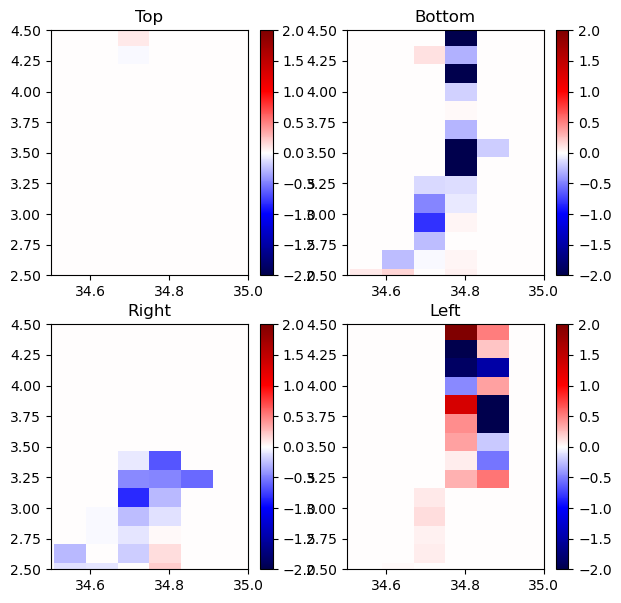

In [170]:
fig = plt.figure(figsize=(7,7))
vlev = 2

ax = plt.subplot(221)
cb=ax.pcolormesh(Sbin,Tbin,J_gates[0],cmap='seismic',vmin=-vlev,vmax=vlev)
ax.set_title("Top")
ax.set_xlim(34.5,35)
ax.set_ylim(2.5,4.5)
plt.colorbar(cb)

ax = plt.subplot(222)
cb=ax.pcolormesh(Sbin,Tbin,J_gates[1],cmap='seismic',vmin=-vlev,vmax=vlev)
ax.set_title("Bottom")
ax.set_xlim(34.5,35)
ax.set_ylim(2.5,4.5)
plt.colorbar(cb)

ax = plt.subplot(223)
cb=ax.pcolormesh(Sbin,Tbin,J_gates[2],cmap='seismic',vmin=-vlev,vmax=vlev)
ax.set_title("Right")
ax.set_xlim(34.5,35)
ax.set_ylim(2.5,4.5)
plt.colorbar(cb)

ax = plt.subplot(224)
cb=ax.pcolormesh(Sbin,Tbin,J_gates[3],cmap='seismic',vmin=-vlev,vmax=vlev)
ax.set_title("Left")
ax.set_xlim(34.5,35)
ax.set_ylim(2.5,4.5)
plt.colorbar(cb)

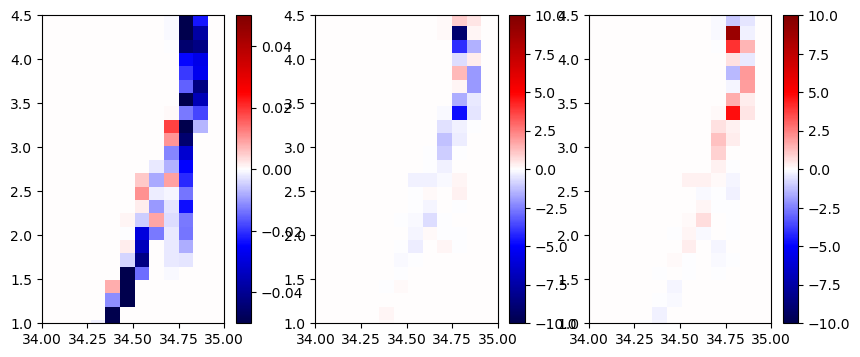

In [171]:
fig = plt.figure()

ax = plt.subplot(131)
cb = ax.pcolormesh(Sbin,Tbin,JtermsS[1],cmap='seismic',vmin=-.05,vmax=.05)
ax.set_xlim(34,35)
ax.set_ylim(1,4.5)
plt.colorbar(cb)

ax = plt.subplot(132)
cb = ax.pcolormesh(Sbin,Tbin,np.nansum(J_gates,axis=0),cmap='seismic',vmin=-10,vmax=10)
ax.set_xlim(34,35)
ax.set_ylim(1,4.5)
plt.colorbar(cb)

ax = plt.subplot(133)
cb = ax.pcolormesh(Sbin,Tbin,JtermsS[1]- np.nansum(J_gates,axis=0) ,cmap='seismic',vmin=-10,vmax=10)
ax.set_xlim(34,35)
ax.set_ylim(1,4.5)
plt.colorbar(cb)

In [174]:
print(np.nansum(JtermsT[1]))

11.93819084943734


In [173]:
print(np.nansum(J_gates))

11.938190849437216
